In [112]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import descartes
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point



from pathlib import Path
import json
from operator import itemgetter
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import nearest_points



p = Path('/Users/eric/Google Sync/sandiegodata.org/Projects/Downtown Partnership Homeless/Uploads')

cols = 'x y width height'.split()

region_ig = itemgetter(*cols)

rows = []
for fn in p.glob('*.json'):
    with fn.open() as f:
        d = json.load(f)['_via_img_metadata']

        for k,v in d.items():
            if k == 'example':
                continue

            image_url = v['filename']

            for region in v['regions']:
                row = [fn,image_url] + list(region_ig(region['shape_attributes'])) + [region['region_attributes']['Intersection']]
                rows.append(row)

df = pd.DataFrame(rows, columns=['source','image']+cols+['intersection'])

intr = pd.read_csv('/Users/eric/proj/data-projects/downtown-partnership/annotations/generate_tasks/gcp_intersections_2230.csv')
intr_gpd = gpd.GeoDataFrame(intr, geometry=intr.WKT.apply(wkt.loads)).drop(columns='WKT')

df = gpd.GeoDataFrame(df.merge(intr_gpd, on='intersection').sort_values(['image', 'neighborhood', 'intersection']))

df['image_x'] = df.x+(df.width/2)
df['image_y'] = df.y+(df.height/2)

df['geo_x'] = df.geometry.x
df['geo_y'] = df.geometry.y

df.to_csv('intersections.csv')

t = df.groupby(['image', 'neighborhood'])

rows = []


def reorder_points(v):
    """Reorder points to ensure the shape is valid"""
    
    return Polygon(list(v.convex_hull.exterior.coords)[:-1])
    
  
for name,g in t:

    g = g.sort_values(['image_y', 'image_x'])

    image_p = Polygon([ [r.image_x, r.image_y] for idx, r in g.iterrows()])

    geo_p = Polygon([[r.geo_x, r.geo_y] for idx, r in g.iterrows()])

    rows.append([name[0], name[1], reorder_points(image_p).wkt, (geo_p).wkt])


df = pd.DataFrame(rows, columns='url neighborhood  source dest'.split())

df.to_csv('poly.csv', index=False)

p = df[df.neighborhood=='marina'].source.apply(wkt.loads)
p

14    POLYGON ((1637 829, 545 840, 548 963, 1636 132...
15    POLYGON ((522 872, 524 991, 1613 1362.5, 1616 ...
16    POLYGON ((541.5 831, 540 956, 1630 1326, 1626 ...
17    POLYGON ((1587.5 562, 427.5 579.5, 430.5 755, ...
18    POLYGON ((455 526, 459 714, 1618.5 1289, 1610 ...
19    POLYGON ((1626.5 503, 470.5 505, 474.5 695, 16...
20    POLYGON ((1620.5 510, 460.5 511, 461 700, 1617...
21    POLYGON ((1610 529, 452.5 531, 455 719, 1611 1...
22    POLYGON ((459 519, 460 707, 1618.5 1286, 1618 ...
23    POLYGON ((468 509, 467 692, 1629 1272, 1622.5 ...
24    POLYGON ((1613 515, 457 518, 460.5 700, 1622.5...
25    POLYGON ((424 545, 427 730, 1581 1313, 1581 55...
26    POLYGON ((1637.5 547.5, 484.5 550.5, 486.5 742...
27    POLYGON ((1564.5 519.5, 405.5 529.5, 413.5 711...
28    POLYGON ((1603.5 560.5, 446.5 571.5, 449.5 757...
29    POLYGON ((1576.5 539.5, 466.5 542.5, 467.5 728...
30    POLYGON ((320.5 366, 318.5 499, 1126.5 904.5, ...
31    POLYGON ((1146 352.5, 338.5 361.5, 338.5 4

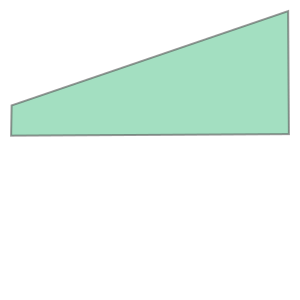

In [111]:
p.loc[15]